In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction import text

stopwords = set(STOPWORDS)
stopwords.add('')

In [52]:
def bagoword(lst):
    cnt = Counter()
    for word in lst:
        cnt[word]+=1
    return cnt

def bagoword_corpus(lst, stopwords):
    cnt = Counter()
    for r in lst:
        for word in wordlist(r):
            if word not in stopwords:
                cnt[word]+=1
    return cnt


def wordlist(review):
    '''
    Convert a review into a list of words(strings).
    '''
    lines = review.split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip().lower(), lines)
    return list(words)

In [53]:
df = pd.read_csv('train.csv')
df.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...


In [54]:
# Feature Engineering

df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['review_length_nonstopwords'] = df['review'].apply(lambda x: len([word for word in (re.sub(r'[^\w]', ' ', x)).lower().split() if word not in stopwords]))

## Data Notes

- 1 = fake review | 0 = genuine review
- 25819 Fake Reviews, 225005 Genuine (250824 total)
    - might require downsampling to balance label distribution
- Mostly 4 & 5 Star Reviews
- some words are very common in both genuine and fake
- 

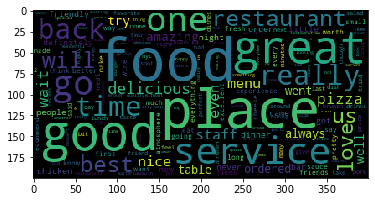

In [55]:
# Fake Review Bag Of Words & WordCloud
bow_fake = bagoword_corpus(df[df['label']==1]['review'], stopwords)
bow_fake_sort = sorted(bow_fake.items(), key=lambda x: x[1], reverse=True)
wc_fake = WordCloud(stopwords=stopwords).generate_from_frequencies(bow_fake)
plt.imshow(wc_fake) 

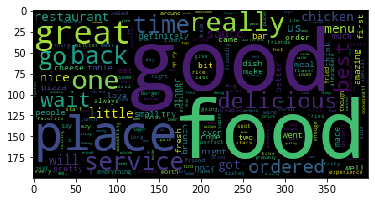

In [56]:
# Genuine Review Bag Of Words & WordCloud
bow_real = bagoword_corpus(df[df['label']==0]['review'], stopwords)
bow_real_sort = sorted(bow_real.items(), key=lambda x: x[1], reverse=True)
wc_real = WordCloud(stopwords=stopwords).generate_from_frequencies(bow_real)
plt.imshow(wc_real) 

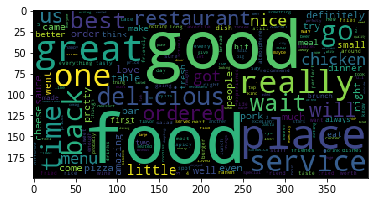

In [57]:
bow_corpus = bagoword_corpus(df['review'], stopwords)
wc = WordCloud(stopwords=stopwords).generate_from_frequencies(bow_corpus)
plt.imshow(wc) 

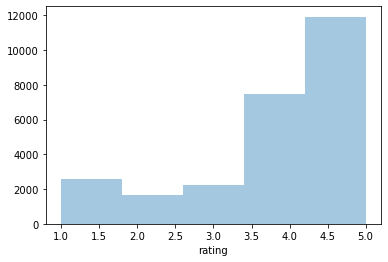

In [58]:
sns.distplot(df[df['label']==1]['rating'], kde=False, bins=5)

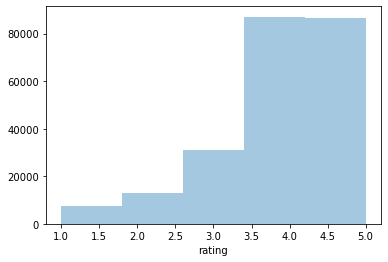

In [59]:
sns.distplot(df[df['label']==0]['rating'], kde=False, bins=5)

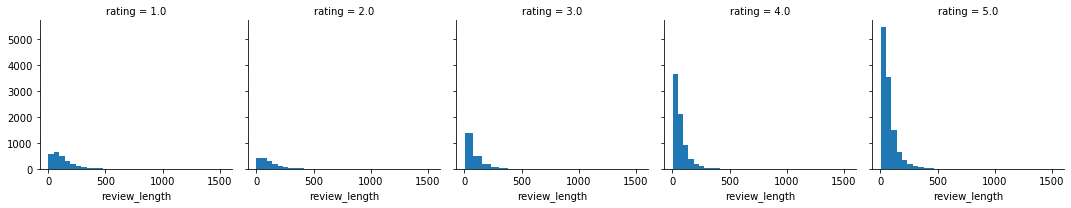

In [60]:
g = sns.FacetGrid(data=df[df['label']==1], col='rating')
g.map(plt.hist, 'review_length', bins=20)

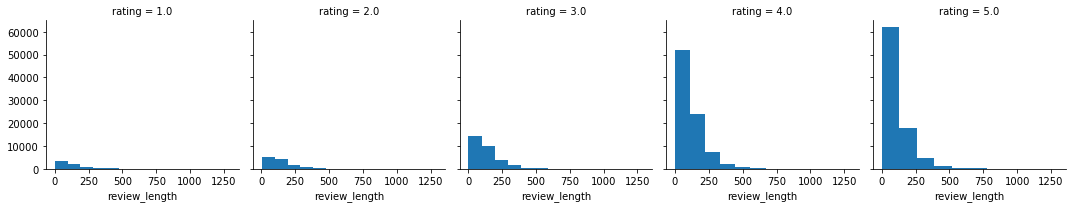

In [61]:
g = sns.FacetGrid(data=df[df['label']==0], col='rating')
g.map(plt.hist, 'review_length', bins=10)

### Build Custom Corpus

- lowercase
- symbol removal with regex
- stopword removal (r_)

In [62]:
rev_lst = []
token_lst = []
for index, row in df['review'].iteritems():
    r = (re.sub(r'[^\w]', ' ', row)).lower()
    r_ = [word for word in r.split() if word not in stopwords]
    rev_lst.append(r)
    token_lst.append(r_)

In [63]:
cv = text.CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1,2))
X = cv.fit_transform(rev_lst)

In [64]:
print(len(cv.get_feature_names()))

4106048


In [65]:
tfid = text.TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1,2))
Y = tfid.fit_transform(rev_lst)

### Representation Notes

- might want to include max_df parameter as a corpus-specific stop condition (check score of noticable words from wordclouds)
- uni + bigrams with word analyzer yields ALOT of features

### Word2Vec

- also doc2vec should be investigated

In [66]:

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec


path = get_tmpfile("word2vec.model")
model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
model = Word2Vec.load("word2vec.model")
model.train([["hello", "world"]], total_examples=1, epochs=1)
vector = model.wv['computer']  # numpy vector of a word
vector.shape

(100,)